In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
pewwork = pd.read_csv('mao-y-data.txt', sep = '\t')

In [ ]:
# binary encode
pewwork_binary = pd.get_dummies(pewwork)

### Hierarchical clustering based feature agglomeration

In [ ]:
from sklearn.metrics import pairwise_distances

distance_matrix = pairwise_distances(np.array(pewwork_binary).T, metric="jaccard")

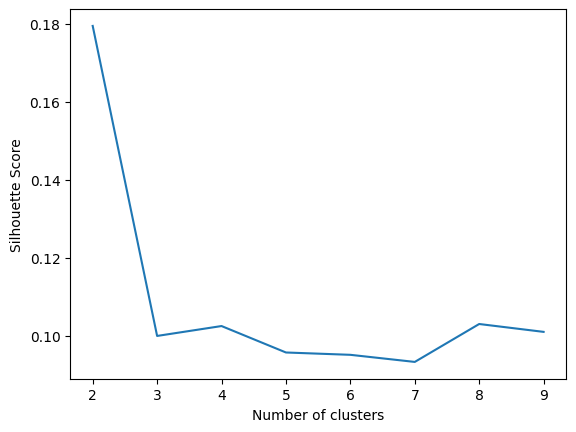

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import FeatureAgglomeration

silhouette_scores = []
for n in range(2, 10):
  agglo = FeatureAgglomeration(
  n_clusters=n,
  metric='precomputed',
  linkage='average')
  agglo.fit(distance_matrix)
  clusters = agglo.labels_
  score = silhouette_score(distance_matrix, clusters)
  silhouette_scores.append(score)

plt.plot(range(2, 10), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.savefig('sihouette_plot.jpg')

In [ ]:
agglo = FeatureAgglomeration(
  n_clusters=2,
  metric='precomputed',
  linkage='average')
agglo.fit(distance_matrix)

def get_feature_agglomeration_clusters(agglo_model, feature_names):
  clusters = {}
  for feature_idx, label in enumerate(agglo_model.labels_):
    if label not in clusters:
      clusters[label] = []
    clusters[label].append(feature_names[feature_idx])
  return clusters

feature_clusters = get_feature_agglomeration_clusters(agglo, pewwork_binary.columns)

### Restricted Boltzmann Machine

In [ ]:
# partition the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(pewwork_binary, test_size=0.2, random_state=42)

In [ ]:
from sklearn.neural_network import BernoulliRBM
from sklearn.model_selection import ParameterGrid

param_grid = {'n_components': [8, 16, 32, 64],
              'n_iter': [10, 100, 200, 300, 400, 500],
              'learning_rate': [0.01, 0.1]}

best_score = float('-inf')
best_params = None

for params in ParameterGrid(param_grid):
  rbm = BernoulliRBM(**params, random_state=0)
  rbm.fit(X_train)
  score = rbm.score_samples(X_test).mean()
  print(f"Parameters: {params}, Score: {score}")
  if score > best_score:
    best_score = score
    best_params = params

print(f"Best parameters: {best_params}")
print(f"Lowest score sample value: {best_score}")


Parameters: {'learning_rate': 0.01, 'n_components': 8, 'n_iter': 10}, Score: -54.89390771130718
Parameters: {'learning_rate': 0.01, 'n_components': 8, 'n_iter': 100}, Score: -47.38129707026526
Parameters: {'learning_rate': 0.01, 'n_components': 8, 'n_iter': 200}, Score: -47.188951659745335
Parameters: {'learning_rate': 0.01, 'n_components': 8, 'n_iter': 300}, Score: -47.138714140483735
Parameters: {'learning_rate': 0.01, 'n_components': 8, 'n_iter': 400}, Score: -46.07547321937216
Parameters: {'learning_rate': 0.01, 'n_components': 8, 'n_iter': 500}, Score: -46.46185899142735
Parameters: {'learning_rate': 0.01, 'n_components': 16, 'n_iter': 10}, Score: -52.72843048086096
Parameters: {'learning_rate': 0.01, 'n_components': 16, 'n_iter': 100}, Score: -45.01669854530865
Parameters: {'learning_rate': 0.01, 'n_components': 16, 'n_iter': 200}, Score: -45.363107480748084
Parameters: {'learning_rate': 0.01, 'n_components': 16, 'n_iter': 300}, Score: -44.250542700785545
Parameters: {'learning_r

In [ ]:
from sklearn.neural_network import BernoulliRBM
rbm = BernoulliRBM(n_components=64, learning_rate=0.01, n_iter=500, random_state=0)
rbm_reduced = rbm.fit_transform(pewwork_binary)

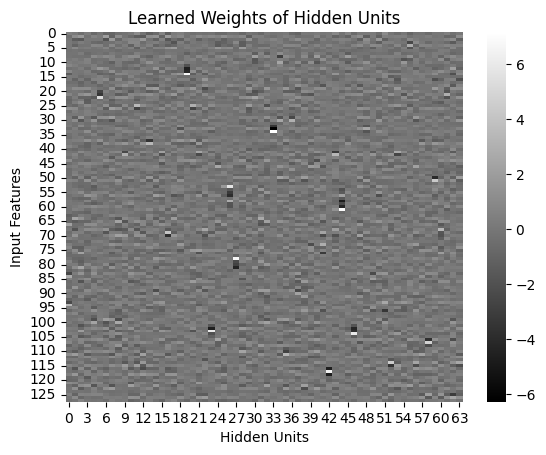

In [ ]:
sns.heatmap(rbm.components_.T, cmap = 'gray')
plt.xlabel('Hidden Units')
plt.ylabel('Input Features')
plt.title('Learned Weights of Hidden Units')
plt.savefig('RBM_loadings.jpg')